# Purified evolution of 1 site coupled to bath
TDVP unitary evolution of a purified density matrix

In [2]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [1]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Statistics

In [ ]:
"""

What to do next:
-P is non-zero when it shouldn't be, i.e. when psi is full rank.
-The problem is that after the centre site, the link dimension of the full rank MPS starts halving, but the code still
expects it to double. 
-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.
-I think I should have error checks for various properties of all the objects, i.e. the norm of ρ_n etc.

-Once the projector is diagonalised, the spectra are either 0 or 1, but numerically they deviate from this by an order of
~1e-14. Is there a way of recovering Vp from the diagonal matrix after the values have been rounded?

-The stochastic enrichment method is much more efficient and seems quite straight forward to implement.

-The bottleneck is the creating the Krylov states, see if you can make the function more efficient (Vectorise?). 

-In the paper, they say to use τ=δt but I'm not sure about this as for small delta t, these states won't be that different (think about this more).

-There's a more efficient but less accurate way to apply H to ψ, by using the variational approach that's used in TDVP itself. 

-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.

-For 1TDVP, they found that for k=5 the creation of the Krylov states and the enrichment step were subleading to the TDVP step, but this isn't
what I have at the moment. 2TDVP is slower than 1TDVP but more accurate, so we don't know if these steps should be subleading to TDVP or not, but 
there's definitely ways of increasing the efficiency of these steps.

-Ask on the discourse page if 1TDVP is implemented as this could be another option.

"""

In [2]:


function enrich_generic2(ϕ, ψ⃗; cutoff=1e-15, kwargs...)
    
  Nₘₚₛ = length(ψ⃗) ##number of MPS

  @assert all(ψᵢ -> length(ψ⃗[1]) == length(ψᵢ), ψ⃗) ##check that all MPS inputs are of the same length

  N = length(ψ⃗[1]) 

  ψ⃗ = copy.(ψ⃗)
    
  ###Isn't this already a vector of MPS's?  
  ψ⃗ = convert.(MPS, ψ⃗)

  s = siteinds(ψ⃗[1])

  ##makes the orthogonality centre for each MPS to be at site N  
  ψ⃗ = orthogonalize.(ψ⃗, N)
  ϕ = orthogonalize!(ϕ, N)
  
  ##storage MPS
  phi = deepcopy(ϕ)
  
  ρϕ = prime(ϕ[N], s[N]) * dag(ϕ[N])
  ρ⃗ₙ = [prime(ψᵢ[N], s[N]) * dag(ψᵢ[N]) for ψᵢ in ψ⃗]
  ρₙ = sum(ρ⃗ₙ)
  ρₙ /=tr(ρₙ)

#   # Maximum theoretical link dimensions
   add_maxlinkdims = _add_maxlinkdims(ψ⃗)

  Cϕprev = ϕ[N]
  C⃗ₙ = last.(ψ⃗)

  maxdim_ϕ = mindim_vec(linkdims(ϕ),2)
  for n in reverse(2:N)
        
    # Diagonalize primary state ψ's density matrix    
    D, Vϕ, spec = eigen(ρϕ; 
      ishermitian = true,
      tags = tags(linkind(ϕ, n - 1)),
      cutoff = 1e-15,
      maxdim =maxdim_ϕ[n-1],
      kwargs...,
    )
 #   println(linkdims(ϕ)[n-1])
    r = uniqueinds(Vϕ, D) # Indices of density matrix
    lϕ = commonind(D, Vϕ) # Inner link index from density matrix diagonalization
        
    # Construct identity matrix
    ID = 1
    rdim = 1
    for iv in r
      IDv = ITensor(dag(iv)', iv);
      rdim *= dim(iv)
      for i in 1:dim(iv)
        IDv[iv' => i, iv => i] = 1.0
      end      
      ID = ID*IDv
    end   
        
    """Problem: When going towards the centre, it's easy to put a limit 
        on the projector dimension as the difference between the true link dimension
        and the twice the previous link dimension. Going away from the centre, this isn't straight forward,
        half the link dimension - the next link dimension doesn't help and will be negative I think. 
        Think more about this."""
        
        
        
        
        
#     if n != N
#         rdim_arr = zeros(2)
#         rdim_arr[1] = dim(r[1])
#         rdim_arr[2] = dim(r[2])
#         if n>N/2
#             rdim = rdim_arr[1]*rdim_arr[2]
#         else
#             rdim = floor(maximum(rdim_arr)/minimum(rdim_arr))
#         end
#     else
#         rdim = dim(r)
#     end
    #@show(rdim)
    P = ID - prime(Vϕ, r)*dag(Vϕ) # Projector on to null-space of ρψ   
    
    C = combiner(r) # Combiner for indices
   # @show(tr(matrix(C'*ρₙ*dag(C)))) 
  #  @show(tr(matrix(C'*P*dag(C))))
  #  @show(Vϕ)
    #chkP = sum(abs.(array(P))) # Check that P is non-zero   
    if abs(tr(matrix(C'*P*dag(C)))) > 1e-10    
        
            
        Dp, Vp, spec_P = eigen(
              P, r', r;
              ishermitian=true,
              tags="P space",
              cutoff=1e-1,
              maxdim=rdim-dim(lϕ),             ###potentially wrong
              kwargs...,
            )
            
        lp = commonind(Dp,Vp)
        #@show(spec_P)   
        #@show(std(spec_P))
        #@show(length(spec_P))
        ##constructing VpρₙVp
           # print("dim of P=",dim(P))
     #   @show(norm(P))
      #  @show(norm(Vp))
        "Going wrong here."
        VpρₙVp = Vp*ρₙ        
        VpρₙVp = VpρₙVp*dag(Vp')
        chkP = abs(tr(matrix(VpρₙVp))) ##chkP<tr(P)
        
    else
        chkP = 0    
    end
    @show(chkP)
    if chkP >1e-10
        
   
        maxdim_ρₙ = mindim_vec(add_maxlinkdims,2)
#          println(maxdim_ρₙ[n-1])
        Dₙ, Vₙ, spec = eigen(VpρₙVp, lp', lp;
          ishermitian=true,
          tags=tags(linkind(ψ⃗[1], n - 1)),
          cutoff=cutoff,
          maxdim=maxdim_ρₙ[n-1],             ###Check this, should be link dim of previous step, or maybe the add_link_dim function
          kwargs...,
        )
        
        Vₙ = Vp*Vₙ

        lₙ₋₁ = commonind(Dₙ, Vₙ)
   #     @show(maxdim_ρₙ[n-1]) 
    #    @show(maxdim_ϕ[n-1])

        # Construct the direct sum isometry 
        V, lnew = directsum(Vϕ => lϕ, Vₙ => lₙ₋₁; tags = tags(linkind(ϕ, n - 1)))
    else
         V = Vϕ
         lnew = lϕ    
    end
  
    # Update the enriched state
    phi[n] = V
        
 
    # Compute the new density matrix for the ancillary states
    C⃗ₙ₋₁ = [ψ⃗[i][n - 1] * C⃗ₙ[i] * dag(V) for i in 1:Nₘₚₛ]   
    C⃗ₙ₋₁′ = [prime(Cₙ₋₁, (s[n - 1], lnew)) for Cₙ₋₁ in C⃗ₙ₋₁]    
    ρ⃗ₙ₋₁ = C⃗ₙ₋₁′ .* dag.(C⃗ₙ₋₁)
    ρₙ₋₁ = sum(ρ⃗ₙ₋₁)
    
    # compute the density matrix for the real state    
    Cϕ = ϕ[n - 1] * Cϕprev * dag(V)
    Cϕd = prime(Cϕ, (s[n - 1], lnew))
    ρϕ = Cϕd * dag(Cϕ) 
        

    Cϕprev = Cϕ
    C⃗ₙ = C⃗ₙ₋₁
    ρₙ = ρₙ₋₁
  
  end
    
    
    phi[1] = Cϕprev
    
    phi = orthogonalize!(phi, N)
    phi[N] = phi[N]/norm(phi)
    

  return phi
end





function Krylov_states(H,ψ,k,τ,s)
    ##Create the first k Krylov states
    Id = MPO(s,"Id")
    Kry_op = Id-im*τ*H
    list = []
    term = copy(ψ)
    for i =1:k-1
        term = noprime(Kry_op*term)
        term = term/norm(term)
        push!(list,term)
    end
    return list
end

# Helpful function for outputing the link dimension profile of an MPS
function linkdims(ψ)
  linkdims = zeros(length(ψ)-1,1)
  for b in eachindex(ψ)[1:(end - 1)]
    l = linkind(ψ, b)
    linkdims[b] = isnothing(l) ? 1 : dim(l)
  end
  return linkdims
end

function _add_maxlinkdims(ψ⃗)
  N = length(ψ⃗[1])
  maxdims = Vector{Int}(undef, N - 1)
  for b in 1:(N - 1)
    maxdims[b] = sum(ψ -> linkdim(ψ, b), ψ⃗)
  end
  return maxdims
end

function mindim_vec(link_vec,d)
    N = length(link_vec)
    v1 = link_vec[1:N-1]
    v2 = link_vec[2:N]
    mindim_vec = min.(v1,d*v2)
    append!(mindim_vec,link_vec[N])
    return mindim_vec
end


function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        for n=1:dim(S, 1)
            p = S[n,n]^2
            SvN[b] -= p * log2(p)
        end
    end
    return SvN
end;

function spectral_density(J,Nb,Γ,D,ϵi)
    ###Need to sort V_k the same way as the energies
    V_k = sqrt(Γ/(2*D))*ones(Nb,1) 
    if Nb>1
        if J== "boxcar"
            V_k = sqrt(Γ/(2*D))*ones(Nb,1)                       # Couplings
            ϵb = collect(range(-1, 1, length = Nb))              # energy of bath modes
        end
        ind = sortperm(abs.(ϵb.-ϵi))                               # Broadcast abs() over vector using "." notation.
        V_k, ϵb = V_k[ind], ϵb[ind];  
    else
        ϵb = 0;
    end
    return V_k, ϵb
end

function rdm(ψ,q)
    ψdag = dag(ψ) # Complex conjugate MPS
    ITensors.prime!(linkinds, ψdag) # Add primes to all MPS bond indices
    # Loop over the sites q whose density matrix is required:
    for j=1:length(q)
        ITensors.noprime!(ψdag[q[j]]) # Remove prime on bond indices of ψdag[q[j]]
        ITensors.prime!(ψdag[q[j]]) # Prime all indices on ψdag[q[j]] including its site index
    end
    # Now contract:
    ρ = ψdag[1] * ψ[1]
    for j in 2:N
      ρ = ρ * ψdag[j] * ψ[j]
    end
    return ρ
end;


function band_diag(B,d)
# Band-diagonalize matrix B with a bandwidth of d:
    n = size(B,1); # Assumed to be square.
    U = Diagonal(ones(n,n));
    for k=1:Int(floor(n/d)-1)
        C = B[(k*d+1):n,((k-1)*d+1):(k*d)]; # Extract coupling matrix.
        F = qr(C); # Upper-triangularize.
        blocks = [[Diagonal(ones(k*d,k*d))]; [F.Q']]
        Q = cat(blocks...,dims=(1,2))    # Form full triangularizing unitary.    
        B = Q*B*Q'; # Apply to input matrix to transform for next step.
        U = Q*U; # Save this step's unitary to the full sequence.
    end
    return B,U; # Return the final band-diagonalized matrix.
end;

function U_thermo(N,f_k)
    U_th = zeros(N,N)
    U_th[1,1],U_th[2,2] = 1,1
    b=0
    for i=3:2:N
        b += 1
        U_th[i,i],U_th[i+1,i+1] = sqrt(1-f_k[b]),-sqrt(1-f_k[b])
        U_th[i,i+1],U_th[i+1,i] = sqrt(f_k[b]),sqrt(f_k[b])
    end
    return U_th
end

function U_chain(N,U1,U2)

    U_tot = zeros(N,N)
    U_tot[1,1],U_tot[2,2] = 1,1
    b1 = 0
    for i=3:2:N
        b2 = 0 # resets the column iteration
        b1 +=1
        for j =3:2:N
            b2 += 1

            U_tot[i,j] = U1[b1,b2]
            U_tot[i+1,j+1] = U2[b1,b2]
        end
    end
    return U_tot
end


###Observer functions
function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(im*current_time)
  end
  return nothing
end

function measure_den(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return expect(psi, "n"; sites=1)
  end
  return nothing
end;

function measure_SvN(; psi, bond, half_sweep)
    if bond == 1 && half_sweep == 2
        return entanglement_entropy(psi)
    end
    return nothing
end

function measure_correlation_matrix(; psi, bond, half_sweep)
    if bond==1 && half_sweep == 2
        return transpose(correlation_matrix(psi,"Cdag","C"))
    end
    return nothing
end


#Error functions
function fidelity(ρ,σ)
    ##make sure ρ and σ are in matrix form
    matrix = sqrt(ρ)*σ*sqrt(ρ)
    matrix = sqrt(matrix)
    fid = tr(matrix)*conj(tr(matrix))
    return fid
end

function trace_dist(ρ,σ)
    matrix = (ρ-σ)*(ρ-σ)'
    matrix = sqrt(matrix)
    return 0.5*tr(matrix)
end


function error_propagation(corr,times,H_single,δt,Ci,N,Krylov_cutoff,k2,cutoff,other_norms,save_bool)
    parameter_string = "N="*string(N)*", δt="*string(δt)*", Krylov cutoff="*string(Krylov_cutoff)*
            ", k2="*string(k2)*", truncation cutoff="*string(cutoff)
    corr_list = copy(corr)
    time_list = copy(times)
    sim_ρ_list = corr_list./tr.(corr_list)
    exact_corr_list = Any[]
    exact_ρ_list = Any[]
    fid_list = Any[]
    trace_list = Any[]
    n = length(times)
    
    pushfirst!(corr_list,Ci)
    pushfirst!(time_list,0)
    pushfirst!(exact_corr_list,Ci)
    pushfirst!(exact_ρ_list,Ci/tr(Ci))
    pushfirst!(sim_ρ_list,Ci/tr(Ci))
    pushfirst!(fid_list,1) 
    pushfirst!(trace_list,0)
    U_step= exp(-im*δt*H_single)
    
    for i =1:n
        corr_term = U_step*(exact_corr_list[i])*U_step'
        ρ_term = corr_term/tr(corr_term)
        fid_term = fidelity(ρ_term,sim_ρ_list[i+1])
        trace_term = abs(trace_dist(ρ_term,sim_ρ_list[i+1]))
        
        push!(exact_corr_list,corr_term)
        push!(exact_ρ_list,ρ_term)
        push!(fid_list,fid_term)
        push!(trace_list,trace_term)
    end
    
    fid_list = fid_list .- 1 ### The fidelity of two identical density matrices is 1
#     println(abs.(trace_list[1]))
#     println(abs.(trace_list[2]))
#     println(abs.(trace_list[5]))
#     println(abs.(trace_list[10]))
#     println(abs.(trace_list[20]))
#     println(abs.(trace_list[30]))
#     println(abs.(trace_list[40]))
#     println(abs.(trace_list[50]))
    
    
    
    
    diff_list = exact_corr_list - corr_list
    perc_diff_norm1_list = opnorm.(diff_list,1)./(opnorm.(exact_corr_list,1))
    perc_diff_norm2_list = opnorm.(diff_list,2)./(opnorm.(exact_corr_list,2))
    perc_diff_norminf_list = opnorm.(diff_list,Inf)./(opnorm.(exact_corr_list,Inf))
    perc_diff_normfrob_list = norm.(diff_list)./(norm.(exact_corr_list,1))
    max_diff_list = maximum.([abs.(diff_list[i]) for i=1:(size(diff_list)[1])]) 
   if other_norms
        plot(time_list,(abs.(perc_diff_norm1_list)),label="p=1 matrix norm")
        plot!(time_list,(abs.(perc_diff_norm2_list)),;label="p=2 matrix norm")
        plot!(time_list,(abs.(perc_diff_norminf_list)),label="p=inf matrix norm")
        plot!(time_list,(abs.(perc_diff_normfrob_list)),label="frobenius norm")
        plot!(time_list,(abs.(fid_list)),label="fidelity - 1")
        display(plot!(time_list,(abs.(trace_list)),label="trace distance,"*parameter_string))
   else
        display(plot(time_list,(abs.(trace_list)),label="trace distance,"*parameter_string))
   end

   if other_norms
        plot(time_list,log10.(abs.(perc_diff_norm1_list)),label="p=1 matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_norm2_list)),;label="p=2 matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_norminf_list)),label="p=inf matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_normfrob_list)),label="frobenius norm")
        plot!(time_list,log10.(abs.(fid_list)),label="fidelity - 1")
        display(plot!(time_list,log10.(abs.(trace_list)),
           label="trace distance,"*parameter_string))
    else
        display(plot(time_list,log10.(abs.(trace_list)),
           label="trace distance,"*parameter_string))
    end
    
    if save_bool
        savefig("error propagation,"*parameter_string*".png") 
    end
    end


function correlation_matrix_statistics(Cf,Cf_test,eps)
   
#     trun_ind1 = findall(x -> (abs(x)>eps), Cf)
#     trun_ind2 = findall(x -> (abs(x)>eps), Cf_test)
#     bool = size(trun_ind1)[1]>size(trun_ind2)[1]
#     if bool
#         trun_ind = trun_ind1
#     else
#         trun_ind = trun_ind2
#     end
#     Cf_trun = Cf[trun_ind]
#     Cf_test_trun = Cf_test[trun_ind]
#     Cf_trun_diff = Cf_trun-Cf_test_trun
    Cf_trun_diff = Cf-Cf_test
    
    norm0 = opnorm(Cf,1)
    norm1 = opnorm(Cf_trun_diff,1)
    norm2 = opnorm(Cf_trun_diff,2)
    norminf = opnorm(Cf_trun_diff,Inf)
    normfrob = norm(Cf_trun_diff)
    
    println("p=1 norm of simulated correlation matrix="*string(norm0))
    println("p=1 norm of truncated difference matrix="*string(norm1))
    println("p=2 norm of truncated difference matrix="*string(norm2))
    println("p=inf norm of truncated difference matrix="*string(norminf))
    println("Frobenius norm of truncated difference matrix="*string(normfrob))
#     println("mean of truncated Cf="*string(mean(broadcast(abs,Cf_trun))))
#     println("mean of truncated Cf_test="*string(mean(broadcast(abs,Cf_test_trun))))
    println("mean of difference ="*string(mean(broadcast(abs,Cf_trun_diff))))
    
    f(x, y) = abs(Cf[x,y])

    display(surface(1:6,1:6,f,title = "Simulated Correlation matrix",
    xlabel = "sites",
    ylabel = "sites"))
    
    h(x,y) =abs(Cf_test[x,y])
    
    display(surface(1:6,1:6,h,title = "Exact correlation matrix",
    xlabel = "sites",
    ylabel = "sites"))
    
    g(x, y) = abs(Cf[x,y]-Cf_test[x,y])

    display(surface(1:6,1:6,g,title = "Difference between simulated and exact",
    xlabel = "sites",
    ylabel = "sites"))
    
    return #Cf_trun_diff

end


###Animation functions


function correlation_heatmap(corr, nframe, site_lim,T,model)
    x=y=1:site_lim
    anim = @animate for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        heatmap(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1),legend=true,c=:Set1_6)
    end
    gif(anim,"correlation_heatmap_anim,T="*string(T)*",model="*string(model)*".gif")
end

function correlation_contour(corr, nframe, site_lim,T,model)
    x=y=1:site_lim
    anim = @animate for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        contour(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1),legend=true)
    end
    gif(anim,"correlation_contour_anim,T="*string(T)*",model="*string(model)*".gif")
end

function correlation_surface_plot(corr, nframe, site_lim,T,model)
    default(legend=false)
    x=y=1:site_lim
    anim = @animate for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        surface(x, y, f,zlim=(0,1),xlabel="sites",ylabel="sites",
             title="animation of correlation matrix over time", c = :blues,clims=(0,1))
    end
    gif(anim,"correlation_surface_plot_anim,T="*string(T)*",model="*string(model)*".gif")
end

function entanglement_animation(SvN, nframe, site_lim, SvN_ylim,T,model)
    anim = @animate for i=1:nframe
        plot(sites[1:site_lim],SvN[i][1:site_lim],ylim=(0,SvN_ylim),
         xlabel="sites",ylabel="entanglement entropy")
    end
    gif(anim,"entanglement_entropy_anim,T="*string(T)*",model="*string(model)*".gif")
end


entanglement_animation (generic function with 1 method)

In [9]:
J = "boxcar"                                 #choice of bath spectral function
N = 100                                     # Number of sites
tdvp_cutoff = 1E-20                               # Truncation allowed per step
Krylov_cutoff = 1E-30
s = siteinds("Fermion", N)                   # Array of site indices  
sites = 1:N                                  # site list
δt = 0.1                                     # Time-step
T = 10;                                       # Total time
T_enrich = 0.5                               # Time when the state is enriched in each step
T_unenriched = T-T_enrich                    # Time when the state is no longer enriched each step
nframe = T/δt                                # Number of time steps
nframe_en = T_enrich/δt
β = 0;                                       #inverse temperature
ϵi = 0.5;                                    # energy of impurity mode
Nb = Int((N-2)/2)                            # number of bath modes
D = 10                                       #half bandwidth
Γ = 0.1                                      # total impurity-bath strength
t = sqrt(Γ/(pi * Nb)) 
V_k, ϵb = spectral_density(J,Nb,Γ,D,ϵi)                        
f_k = 1 ./(1 .+exp.(β*ϵb))                   # Fermi distributions of the bath modes
k1 = 5
k2 = 3                                       # Number of Krylov states
τ_Krylov = 1
###Construct arrays of local operators

c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cd = ops(s, [("Cdag", n) for n in sites]);    # creation operators
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identiy operators
end;


###Constructs Initial state
vac = productMPS(s, "0");

print("bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3")

choice = parse(Int,readline())
if choice == 1
    #gates = [(cd[n]*Id[n+1] + Id[n]*cd[n+1])/sqrt(2) for n in 3:2:N]; 
    gates = [(sqrt(f_k[Int((n-1)/2)])*cd[n]*Id[n+1] + sqrt(1-f_k[Int((n-1)/2)])*Id[n]*cd[n+1])/sqrt(2) for n in 3:2:N]; 
end

if choice==2 || choice==3
     gates = [cd[n]*Id[n+1] for n in 3:2:N]
     
end
system_gate = (cd[1]*Id[2] + Id[1]*cd[2])/sqrt(2)
if N>2
    push!(gates,system_gate)
else
    gates = system_gate
end
ψ = apply(gates,vac;cutoff=1e-15);


#The following code is not optimised, various objects are created multiple times
#and within each different option there is identical code which doesn't
#need to be written multiple times.




###Create Hamiltonian MPO 
terms = OpSum()
###Create single particle matrix hamiltonian
H_single = zeros(N,N)

### For all choices, the first two indices are the system ancilla and the system respectively.
terms += ϵi,"n",2;
H_single[2,2] = ϵi
b = 0


if choice ==1
    print("negative ancilla H = -1, no ancilla H = 0, positive ancilla H = 1")
    HA_choice = parse(Int,readline()) 
    model =  "E basis,"
    if HA_choice ==1
        model = model*"Ha=Hb"
    end
    if HA_choice ==0
        model = model*"Ha=0"
    end
    if HA_choice ==-1
        model = model*"Ha=-1"
    end
    for j=3:2:N
        b += 1
        terms += ϵb[b],"n",j                                   # bath mode self energy
        H_single[j,j] = ϵb[b]
        
        terms += HA_choice*ϵb[b],"n",j+1                       # ancilla bath mode self energy
        H_single[j+1,j+1] =  HA_choice*ϵb[b]
        
        terms += V_k[b],"Cdag",j,"C",2                         #hopping from system to kth f mode 
        H_single[j,2] = V_k[b]
        
        terms += conj(V_k[b]),"Cdag",2,"C",j                   #hopping from kth f mode to system 
        H_single[2,j] = conj(V_k[b])
    end    
end

if choice==2
    model = "thermofield basis"
    for j=3:2:N
        b += 1
        terms += ϵb[b],"n",j                                   # filled mode self energy
        H_single[j,j] = ϵb[b]
        
        terms += ϵb[b],"n",j+1                                 # empty mode self energy
        H_single[j+1,j+1] =  ϵb[b]
        
        terms += V_k[b]*sqrt(f_k[b]),"Cdag",j,"C",2            #hopping from system to kth f mode
        H_single[j,2] = V_k[b]*sqrt(f_k[b])
        
        terms += conj(V_k[b])*sqrt(f_k[b]),"Cdag",2,"C",j      #hopping from kth f mode to system 
        H_single[2,j] = conj(V_k[b])*sqrt(f_k[b])
        
        terms += -V_k[b]*sqrt(1-f_k[b]),"Cdag",j+1,"C",2        #coupling from system to kth e mode
        H_single[j+1,2] =  -V_k[b]*sqrt(1-f_k[b])
        
        terms += -conj(V_k[b])*sqrt(1-f_k[b]),"Cdag",2,"C",j+1  #coupling from kth e mode to system
        H_single[2,j+1] =  -conj(V_k[b])*sqrt(1-f_k[b])
    end
end

if choice ==3
    model = "thermofield+tridiag"
    fill_mat = zeros(Nb+1,Nb+1)
    emp_mat = zeros(Nb+1,Nb+1)
    ### Same terms as for choice 2, inputed as a matrix rather than an MPO. 
    for j=1:Nb
        ###This loop creates two (Nb+1) x (Nb+1) matrices, one includes the couplings and self energies of the 
        ###filled modes and the system, the other the empty modes and the system. These are then tridiagonalised 
        ###separately in the next loop, and their elements are used to construct the MPO for the hamiltonian in this new, tridiagonal basis. 
    
        fill_mat[1,1],emp_mat[1,1] = ϵi, ϵi

        fill_mat[j+1,j+1],emp_mat[j+1,j+1] = ϵb[j],ϵb[j]

        fill_mat[j+1,1] = V_k[j]*sqrt(f_k[j])

        fill_mat[1,j+1] = conj(V_k[j])*sqrt(f_k[j])

        emp_mat[j+1,1] = V_k[j]*sqrt(1-f_k[j])

        emp_mat[1,j+1] = conj(V_k[j])*sqrt(1-f_k[j])
    end

    fill_mat,Uf = band_diag(fill_mat,1)
    emp_mat,Ue = band_diag(emp_mat,1)

    Uf = Uf[2:Nb+1,2:Nb+1] ###discarding the system terms as the system isn't mixed in this transformation.
    Ue = Ue[2:Nb+1,2:Nb+1]
    
    b = 1
    for j=3:2:N
        b += 1
        terms += fill_mat[b,b],"n",j
        H_single[j,j] = fill_mat[b,b]
        
        terms += emp_mat[b,b],"n",j+1
        H_single[j+1,j+1] = emp_mat[b,b]
        
        terms += emp_mat[b-1,b],"Cdag",j-1,"C",j+1
        H_single[j-1,j+1] = emp_mat[b-1,b]
        
        terms += emp_mat[b,b-1],"Cdag",j+1,"C",j-1
        H_single[j+1,j-1] = emp_mat[b,b-1]
        if j==3
            terms += fill_mat[b-1,b],"Cdag",2,"C",3
            H_single[2,3] = fill_mat[b-1,b]
            
            terms += fill_mat[b,b-1],"Cdag",3,"C",2
            H_single[3,2] = fill_mat[b,b-1]
        else
            terms += fill_mat[b-1,b],"Cdag",j-2,"C",j
            H_single[j-2,j] = fill_mat[b-1,b]
            
            terms += fill_mat[b,b-1],"Cdag",j,"C",j-2
            H_single[j,j-2] = fill_mat[b,b-1]
        end
    end
end
H = MPO(terms,s);

println("here1")
k1 = 4
@time Krylov = Krylov_states(H,ψ,k1,τ_Krylov,s);
println("here2")
###Initial Correlations
ψ[N]= ψ[N]/norm(ψ)
println("here3")
@time ψ1 = enrich_generic2(ψ, Krylov; Krylov_cutoff);
println("1 - overlap of initial state and enriched initial state = ",1-inner(ψ,ψ1))
ψ = ψ1
Ci = transpose(correlation_matrix(ψ,"Cdag","C"));
println("here4")

###Initial Entropy
SvN_init = entanglement_entropy(ψ);


###density of initial state
num_init = expect(ψ,"n");

###Initial state
ψ_init = deepcopy(ψ); 


bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3stdin> 3
here1
  5.095314 seconds (723.68 k allocations: 3.940 GiB, 6.96% gc time)
here2
here3
chkP = 2.9960060034082117e-26
chkP = 1.4451625341182549e-24
chkP = 1.620751772587477e-25
chkP = 3.764315709975059e-23
chkP = 4.071889794598848e-23
chkP = 1.4120298759493494e-26
chkP = 4.595989256054893e-24
chkP = 9.863481324178878e-24
chkP = 2.3878849014184837e-25
chkP = 7.23657549124775e-26
chkP = 3.806071546791221e-25
chkP = 1.2733747816729452e-29
chkP = 1.4724104619048258e-25
chkP = 2.355206615823967e-27
chkP = 1.5031678721706296e-25
chkP = 2.483414736246943e-25
chkP = 8.094965724596912e-26
chkP = 2.2913329181907227e-28
chkP = 3.2026181644689553e-26
chkP = 1.956921177517138e-25
chkP = 5.47767868997778e-24
chkP = 9.46466291846863e-27
chkP = 1.4411017935286418e-25
chkP = 1.3397073346797397e-31
chkP = 6.890839160489448e-24
chkP = 2.3659515073560715e-34
chkP = 1.5721057426130265e-24
chkP = 4.770528037037477e-25
chkP = 2.503

In [99]:
x = Vector{Int}(undef,9)
x[1] = 2
x[2] = 4
x[3] = 8
x[4] = 16
x[5] = 32
x[6] = 16
x[7] = 8
x[8] = 4
x[9] = 2



ψ = randomMPS(s;linkdims=x)

k1 = 20
Krylov = Krylov_states(H,ψ,k1,τ_Krylov,s);
println("here2")
###Initial Correlations
ψ[N]= ψ[N]/norm(ψ)
println("here3")
ψ1 = enrich_generic2(ψ, Krylov; Krylov_cutoff);

here2
here3
tr(matrix(C' * ρₙ * dag(C))) = 1.0 + 0.0im
tr(matrix(C' * P * dag(C))) = 0.0
Vϕ = ITensor ord=2
Dim 1: (dim=2|id=876|"Fermion,Site,n=10")
Dim 2: (dim=2|id=530|"Link,l=9")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 -0.9174884029493482   0.3977625302280929
 -0.3977625302280929  -0.9174884029493482
chkP = 0
tr(matrix(C' * ρₙ * dag(C))) = 18.999999999999996 + 0.0im
tr(matrix(C' * P * dag(C))) = -1.3322676295501878e-15
Vϕ = ITensor ord=3
Dim 1: (dim=2|id=756|"Fermion,Site,n=9")
Dim 2: (dim=2|id=530|"Link,l=9")
Dim 3: (dim=4|id=559|"Link,l=8")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×4
[:, :, 1] =
 -0.5425724550963811   0.3969709557799
 -0.7007723853912344  -0.2386362401458716

[:, :, 2] =
 -0.5109452989898902   0.3241378300347758
  0.33294149875377155  0.7232008897865593

[:, :, 3] =
 0.18815184510216038   0.7761508840569615
 0.43545606478489085  -0.4154114875690212

[:, :, 4] =
  0.6396474932300373   0.36733980533715277
 -0.45655890958640677  0.49746006261474246
chkP

 0.08907605378379664   0.20989970092478183  0.003290397706321122  -0.1796212673436575   -0.2782316064725749      0.11942250201828897   0.17109549281286288   0.30217667788137087  0.017178207626778103  0.23430509244274364  -0.19730764181446186  0.022841946739443078  -0.24116234734475966    -0.09024369503666636  0.23288279533351106  0.17774006817678786
chkP = 0
tr(matrix(C' * ρₙ * dag(C))) = 18.999999999999996 + 0.0im
tr(matrix(C' * P * dag(C))) = 48.0
Vϕ = ITensor ord=3
Dim 1: (dim=2|id=816|"Fermion,Site,n=5")
Dim 2: (dim=32|id=154|"Link,l=5")
Dim 3: (dim=16|id=277|"Link,l=4")
NDTensors.Dense{Float64, Vector{Float64}}
 2×32×16
[:, :, 1] =
  0.7876099139034798    -0.010683429352933782  -0.009855538421277898  -0.022103605488072126   0.025510556044215888  0.0392078696812341    0.007826759512557926  -0.019511785376181673  -0.015158342607694502   0.00087376076500107   0.015248360791667791   0.0040825862224544065  0.0023281693186269978  0.00280861831853321    0.007334636751351232  -0.003723406

 -0.0657336561721963   -0.02515426454587007  0.0691441792660027  0.025028948655325782  -0.16919540900641084  0.0490351752604217    0.005036354601501274  -0.022774426899443832   0.17575087092100936  -0.005554904455152055  -0.008066550543297387   0.10579583796076752  -0.10856125658967929  -0.0053802988749473545  0.08812998803673325  0.10515810335983972  -0.004636808799820168  -0.26205949352319496   0.07132010999171225    -0.16328216908606902  -0.028430413094978044  -0.1893883266075723  0.03151758510614015    0.13141580437266542  -0.12340277609603811  0.038726837576327236  0.12750292217793946  -0.05180758100745546   -0.004980085931876839  0.15335215621163148   -0.1281362611601507    0.0018047547020926813
chkP = 13.213790103266447
tr(matrix(C' * ρₙ * dag(C))) = 18.381188156394952 + 1.8584981793949077e-18im
tr(matrix(C' * P * dag(C))) = 112.0 - 2.8837190245440165e-17im
Vϕ = ITensor ord=3
Dim 1: (dim=2|id=223|"Fermion,Site,n=4")
Dim 2: (dim=60|id=452|"Link,l=4")
Dim 3: (dim=8|id=194|"Link,l=

 0.008370746733885312 + 0.026015257783196712im  -0.029014564826728005 - 0.09017372112439125im   0.04356625883385415 + 0.1353986074343962im  -0.014900721368241132 - 0.04630962072760329im  0.020345367233189648 + 0.0632309145973985im  0.011318057251612737 + 0.03517513855135175im  0.03655208850773141 + 0.11359942338216675im   0.03207958607745366 + 0.09969943250930512im  -0.029586077731391915 - 0.09194991336183757im  -0.05731547887563243 - 0.17812950279826104im    0.016812207032598885 + 0.052250284542189884im   0.04789255533405026 + 0.1488442081765523im   -0.02115787728021383 - 0.0657560965040587im   0.11498773862285228 + 0.3573678369396795im  -0.12250904875828467 - 0.3807431495316688im   -5.1261316063901826e-5 - 0.00015931390479483537im  -8.682208310981787e-11 - 3.306079129021635e-10im   -4.6597554609261195e-11 - 6.775507860444636e-11im   1.5351036785700407e-10 + 5.357590102278782e-10im  -1.520324300436176e-10 - 3.8712825578384086e-10im  -1.7798631257816904e-10 - 3.058074453005105e-10im   

 -0.08389366524155041 - 0.33749259013688143im   0.06834772894334654 + 0.4636251447056041im   0.0028795169578170396 + 0.1275603458761712im    0.06065530022696797 - 0.018306151144276875im  0.19971523951761183 - 0.07315574719000359im   -0.004809497499352653 + 0.01655712506682176im  0.25582304335246947 - 0.40061861376980445im   -0.0005087026080183228 - 0.002246026313133083im  -9.705903190277327e-14 + 8.753992513798449e-13im   2.8862791153144174e-13 + 1.3551688388225954e-13im  2.7375743519080064e-13 - 1.3815799748095155e-13im  -1.1499395661652393e-12 - 9.240428376080482e-13im    2.2952708906317256e-14 - 4.980807029538523e-13im   -6.420355495848705e-13 - 3.083540325480576e-13im  -1.7776601209652027e-13 + 6.355591583901155e-13im   -4.0925381432225544e-13 + 1.761734527037389e-13im   1.0985657492009989e-13 - 1.7656838509861484e-13im   4.785013095124885e-13 - 5.910746695325469e-13im    -9.318967737159886e-13 - 1.383301426634014e-13im   -2.868213654139511e-13 + 1.518298690324723e-13im   -2.505669

chkP = 13.070100006424529


In [5]:
linkdims(ψ)

99×1 Matrix{Float64}:
 2.0
 4.0
 4.0
 3.0
 2.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Number Operator expectation values
1     0.5
2     0.5
3     1.0000000000000002
4     0.0
5     1.0000000000000002
6     0.0
7     1.0000000000000002
8     0.0
9     1.0000000000000002
10    0.0


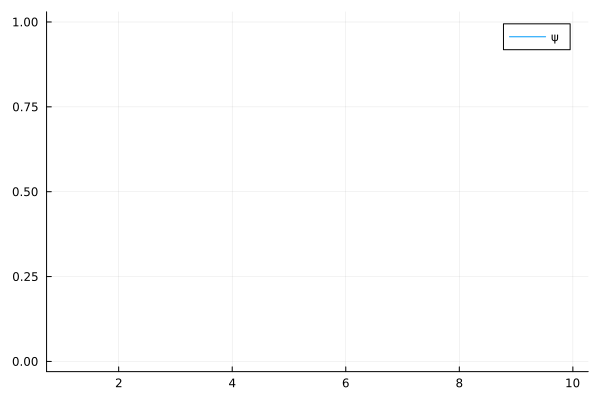

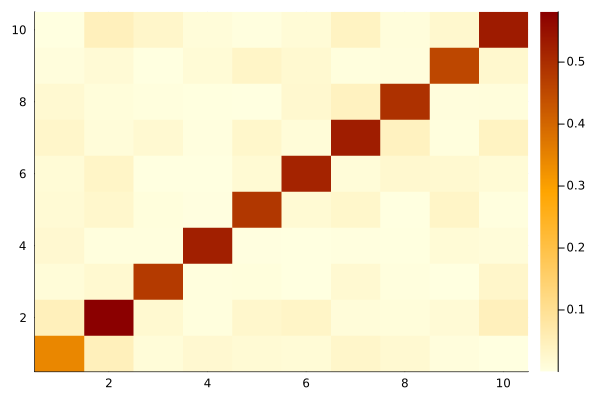

In [216]:
println("Number Operator expectation values")
for j in sites
     println(rpad(j,6," "),num_init[j])
end
display(plot(sites, SvN_init, label="ψ"))

gr()
display(heatmap(sites, sites, abs.(Ci), c = :heat))

In [172]:

ψ = randomMPS(s;linkdims=x)
Ci = transpose(correlation_matrix(ψ,"Cdag","C"));

In [173]:
linkdims(ψ)

9×1 Matrix{Float64}:
 32.0
 32.0
 32.0
 32.0
 32.0
 16.0
  8.0
  4.0
  2.0

In [149]:
x = Vector{Int}(undef,9)
for i=1:9
    x[i] = 32
end

In [7]:
tdvp_cutoff = 0#1e-30 ##TRY ZERO
Krylov_cutoff = 1e-5
δt1 = 1e-2                                   # Time-step
δt2 = 1e-2
δt = 1e-2
frac = 1#Int(δt/δt1)
T = 1e-1                                       # Total time
T_enrich = 1e-1# Time when the state is enriched in each step
T_unenriched = T-T_enrich                    # Time when the state is no longer enriched each step

nframe = Int(ceil(T/δt1))                                # Number of time steps
nframe_en = Int(ceil(T_enrich/δt1))
nframe_un =  Int(ceil(T_unenriched/δt2))

k2=3
ψe = deepcopy(ψ)
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN)
for i =1:(nframe_en/frac)
 #   println(linkdims(ψe))
    ψe = tdvp(H,-im * δt,ψe; time_step = -im * δt1, cutoff = tdvp_cutoff, outputlevel=1, normalize=false, (observer!)=obs)#,solver_krylovdim=70,solver_tol=1e-30)
  #  println(linkdims(ψe))
    @time Krylov_i = Krylov_states(H,ψe,k2,τ_Krylov,s);
    @time ψe2 = enrich_generic2(ψe, Krylov_i; Krylov_cutoff);
  #  @show(linkdims(ψe2))
   # println(1-inner(ψe2,ψe))
    ψe = ψe2
    
end

@time ψf = tdvp(H,-im * T_unenriched,ψe; time_step = -im * δt2, cutoff = tdvp_cutoff, outputlevel=1, normalize=false, (observer!)=obs)

res = results(obs)
times = res["times"]
corr = res["corr"]
SvN = res["SvN"];

#display(plot(times, den, label="line"))
#display(scatter!(times, den, label="points"))

###exact propagation
### Correlation functions evolve as U'*Ci*U, not the other way around.
U= exp(-im*T*H_single);
Cf_test = U*Ci*U';
#Cf = transpose(correlation_matrix(ψf,"Cdag","C"));


After sweep 1: maxlinkdim=16 maxerr=0.00E+00 current_time=0.0 - 0.01im time=7.218
  0.506383 seconds (598.16 k allocations: 483.507 MiB, 11.05% gc time)
chkP = 3.0099814838367976e-27
chkP = 1.6969765487578078e-28
chkP = 5.463928649436137e-28
chkP = 1.300093971497087e-29
chkP = 9.036041567699592e-32
chkP = 3.2005593123620995e-29
chkP = 3.5930908773513077e-28
chkP = 1.2210572686463266e-28
chkP = 5.829100955066265e-28
chkP = 1.1453498194464823e-29
chkP = 6.477519265575779e-28
chkP = 3.1929113260741964e-28
chkP = 3.56138191835984e-29
chkP = 3.462119334980048e-29
chkP = 2.4828045495680762e-29
chkP = 3.9957783562825163e-28
chkP = 1.073804513893382e-28
chkP = 1.142584598606827e-22
chkP = 5.663687578396555e-23
chkP = 8.356492862876247e-24
chkP = 5.409720112703765e-27
chkP = 2.518226403338565e-26
chkP = 1.2732810121292059e-27
chkP = 2.727649888144116e-30
chkP = 1.45778590005944e-23
chkP = 8.52219354608813e-24
chkP = 4.730151234840719e-23
chkP = 1.8321099983453484e-23
chkP = 9.120967665029594e-2

After sweep 1: maxlinkdim=44 maxerr=0.00E+00 current_time=0.0 - 0.01im time=0.328
  6.751159 seconds (601.54 k allocations: 4.777 GiB, 8.15% gc time)
chkP = 8.906488927196109e-25
chkP = 4.920000747958524e-25
chkP = 7.2929179733326025e-25
chkP = 2.093600091533216e-25
chkP = 5.239522486617743e-26
chkP = 3.2450944576296465e-26
chkP = 2.2778906451838885e-25
chkP = 4.4125996716832524e-27
chkP = 9.694407289495379e-26
chkP = 5.531126453195262e-26
chkP = 4.418413196594335e-26
chkP = 1.690338766632324e-28
chkP = 2.1571980736894775e-26
chkP = 4.574084121470498e-30
chkP = 1.967108353277828e-25
chkP = 1.7201339406544255e-26
chkP = 4.168444394133701e-25
chkP = 1.9421749033061022e-25
chkP = 3.0448474648914137e-26
chkP = 8.959805956006805e-27
chkP = 8.901289792707125e-26
chkP = 3.106763630278969e-26
chkP = 2.7334046899806155e-26
chkP = 2.7940539425396063e-26
chkP = 7.979934992385374e-27
chkP = 4.368309164567738e-26
chkP = 2.8194703979831654e-24
chkP = 3.30935130367478e-24
chkP = 9.495110669422607e-25

chkP = 4.966858494364465e-29
chkP = 1.3178866080441447e-28
chkP = 7.167147510440022e-29
chkP = 1.52059774153e-28
chkP = 2.1219518055000124e-29
chkP = 2.3234112115701543e-30
chkP = 9.874651495747431e-29
chkP = 8.705724792163606e-29
chkP = 1.3885191306012672e-28
chkP = 5.742800736689115e-29
chkP = 3.4050490636824347e-28
chkP = 5.793257582706737e-28
chkP = 4.428439770913583e-28
chkP = 4.9211135981773556e-26
chkP = 4.999040096007308e-29
chkP = 6.211069855703725e-23
chkP = 1.716594161656965e-17
chkP = 3.42870711263814e-13
chkP = 3.4191849284459075e-13
chkP = 3.3264223167201968e-9
chkP = 3.3325726981725345e-9
chkP = 4.1365501428711596e-9
chkP = 1.7043685710534726e-9
chkP = 6.004076532517437e-6
chkP = 1.1707307009834479e-5
chkP = 9.21735984963093e-6
chkP = 0.024024787856160093
chkP = 0.4332602349254717
  0.463043 seconds (246.36 k allocations: 279.517 MiB, 10.63% gc time)
After sweep 1: maxlinkdim=60 maxerr=0.00E+00 current_time=0.0 - 0.01im time=0.335
 28.602408 seconds (601.58 k allocations

chkP = 3.2591351102848076e-20
chkP = 2.098137190757069e-22
chkP = 2.948094377911237e-20
chkP = 5.646078367685791e-22
chkP = 3.9705636666146966e-21
chkP = 8.604886847997504e-21
chkP = 4.144890764628393e-21
chkP = 3.866702491322648e-22
chkP = 1.0338287417770392e-19
chkP = 7.988987379407475e-22
chkP = 1.525976246436259e-20
chkP = 3.33924055642076e-21
chkP = 2.4449331636929718e-21
chkP = 4.728896330092335e-20
chkP = 1.1182714909125035e-20
chkP = 4.4593574849982725e-20
chkP = 7.084322855789337e-21
chkP = 4.987846122142852e-21
chkP = 6.489463629862009e-21
chkP = 1.3884680963776337e-21
chkP = 1.5699648458873415e-21
chkP = 4.8965590315981594e-21
chkP = 4.87747012569309e-16
chkP = 4.782668838996993e-16
chkP = 4.0207932793662666e-12
chkP = 4.018666027986134e-12
chkP = 0
chkP = 6.885748729123505e-13
chkP = 4.138263042446724e-9
chkP = 8.365119621371635e-9
chkP = 3.813618123965226e-7
chkP = 1.0088558034669787e-6
chkP = 1.966376123508195e-5
chkP = 0.024259056825897154
chkP = 0.35569179381865496
  0.

In [61]:
nframe_un

-4

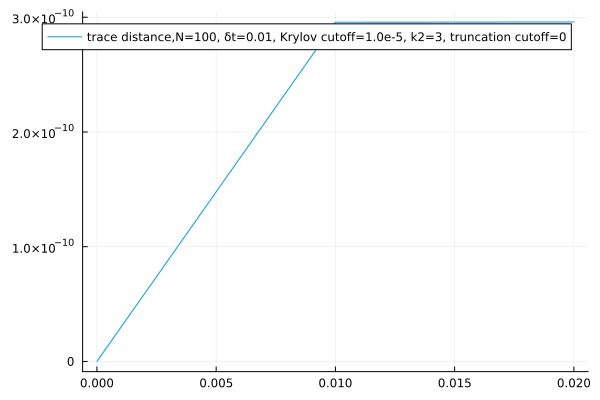

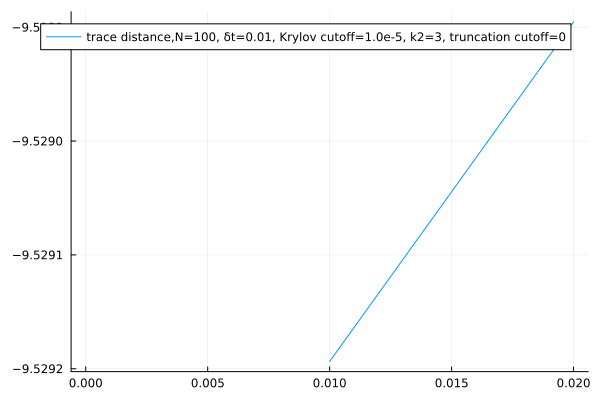

LoadError: MethodError: no method matching iterate(::Nothing)
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:872
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m) at range.jl:872
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}} at dict.jl:712
[0m  ...

In [7]:
# #x is exact,y is simulated
other_norms=false
save_bool = false
times = Vector(LinRange(δt1,T_enrich,Int(nframe_en)))
times2 = Vector(LinRange(T_enrich+δt2,T,Int(nframe_un)))
append!(times,times2)
#times =Vector(LinRange(δt1,T_enrich,Int(nframe_en)))
x,y = error_propagation(corr,times,H_single,δt1,Ci,N,Krylov_cutoff,k2,tdvp_cutoff,other_norms,save_bool)
#error_propagation(corr,times,H_single,δt,Ci,N,δt,Krylov_cutoff,k2,cutoff,other_norms)

In [237]:
(corr[1]-Cf_test)[1:6,1]

6-element Vector{ComplexF64}:
  -6.661338147750939e-16 + 0.0im
   2.220446049250313e-16 - 3.308722450212111e-24im
  -8.838834764831836e-17 - 3.5355339059327305e-9im
  -8.838834764831837e-17 - 3.5355339059327305e-9im
 -1.7677669529663669e-16 + 2.9462782549439442e-24im
  -1.767766952966367e-16 + 2.9462782549439457e-24im

In [48]:
Krylov_cutoff

1.0e-10

In [139]:
Int(ceil(T_enrich/δt1))#/frac

100

In [147]:
#frac = Int(ceil(δt2/δt))
Int(δt/δt2)

10

In [54]:
linkinds(ψ)

19-element Vector{Index{Int64}}:
 (dim=2|id=917|"Link,n=1")
 (dim=4|id=300|"Link,l=2")
 (dim=8|id=299|"Link,n=1")
 (dim=16|id=601|"Link,l=4")
 (dim=29|id=883|"Link,n=1")
 (dim=43|id=176|"Link,l=6")
 (dim=29|id=727|"Link,n=1")
 (dim=15|id=777|"Link,l=8")
 (dim=29|id=571|"Link,n=1")
 (dim=36|id=408|"Link,l=10")
 (dim=41|id=841|"Link,n=1")
 (dim=43|id=722|"Link,l=12")
 (dim=23|id=515|"Link,n=1")
 (dim=12|id=726|"Link,l=14")
 (dim=23|id=540|"Link,n=1")
 (dim=16|id=414|"Link,l=16")
 (dim=8|id=52|"Link,n=1")
 (dim=4|id=9|"Link,l=18")
 (dim=2|id=477|"Link,n=1")

In [94]:
# site_lim = 50
# SvN_ylim = 5
# entanglement_animation(SvN, nframe, site_lim, SvN_ylim,T,model)
# #model

In [151]:
times

10-element Vector{Float64}:
 0.01
 0.12
 0.22999999999999998
 0.33999999999999997
 0.44999999999999996
 0.56
 0.6699999999999999
 0.78
 0.8899999999999999
 1.0

In [132]:
times

12-element Vector{Float64}:
 0.05
 0.1
 0.15
 0.2
 0.30000000000000004
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [101]:
x = [1,2,3,4,5]
y = [6,7,8,9]
append!(x,y)

9-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8
 9

1     0.5000000063563533
2     0.5000000073066664
3     0.9741984675720228
4     0.025801512749825062
5     0.9976117501693338
6     0.0023882584670733716
7     0.9999218851085436
8     7.810938125970871e-5
9     0.9999986379361645
10    1.3642019275505448e-6
11    0.9999999851855992
12    1.4503061069851368e-8
13    0.9999999998493813
14    4.437875359791437e-10
15    0.9999999998495958
16    1.564312591023383e-10
17    0.9999999999206165
18    5.921377443168375e-11
19    0.9999999998237296
20    1.1757559527697703e-10
21    0.9999999999285278
22    3.534209627236812e-11
23    0.9999999999641782
24    6.199992332111073e-11
25    0.9999999999052763
26    4.4318807060021496e-11
27    0.9999999999878072
28    4.997794400088886e-11
29    0.9999999997731894
30    2.542581107222925e-10
31    0.9999999999429411
32    3.795352222422968e-11
33    0.9999999999674767
34    2.5769668576224552e-11
35    0.9999999999889538
36    4.35236454651613e-11
37    0.9999999999652207
38    2.1032354334102523

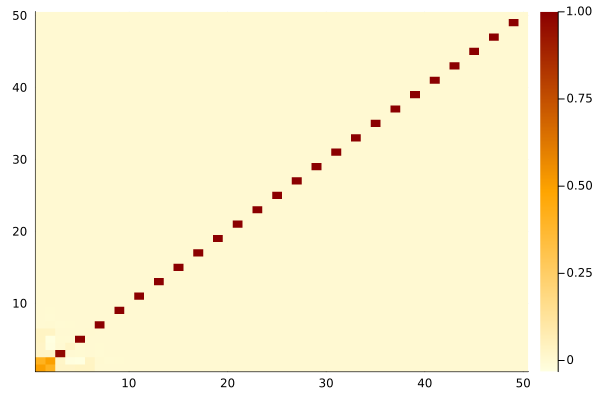

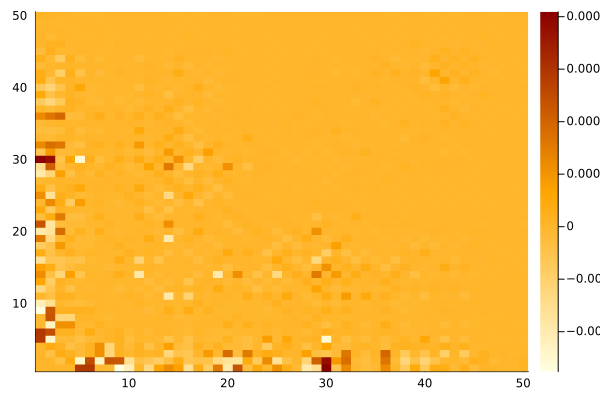

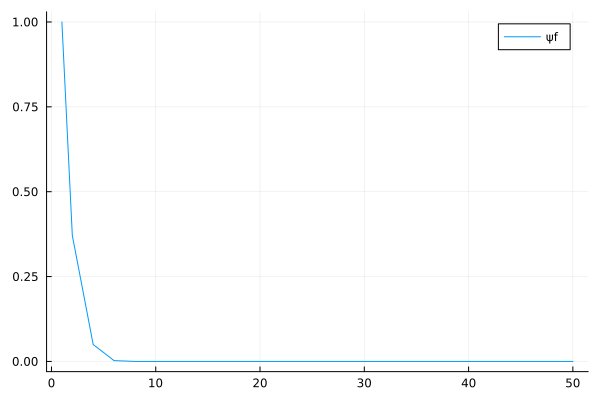

In [73]:
###Plotting of final state

num = expect(ψf,"n");
for j in sites
    println(rpad(j,6," "),num[j])
end


Cf = correlation_matrix(ψf,"Cdag","C");
gr()
display(heatmap(sites, sites, real(Cf), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)


gr()
display(heatmap(sites, sites, real(Cf - Cf_test), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

SvN = entanglement_entropy(ψf);
display(plot(sites, SvN, label="ψf"))


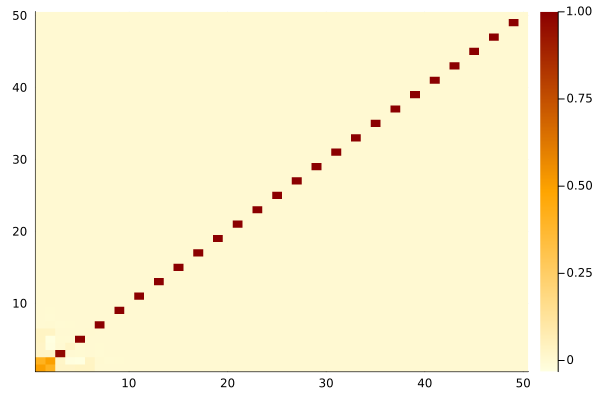

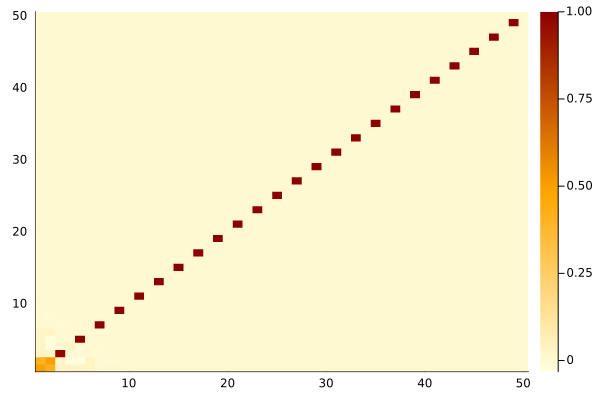

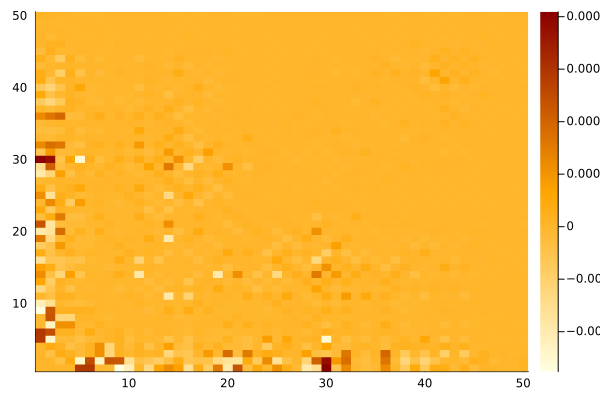

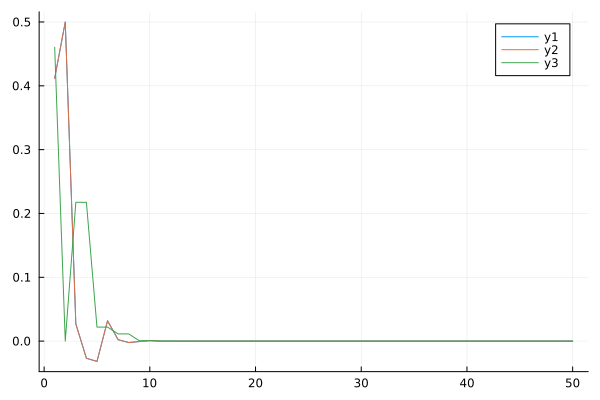

In [74]:

gr()
display(heatmap(sites, sites, real(Cf), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

gr()
display(heatmap(sites, sites, real(Cf_test), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)




gr()
display(heatmap(sites, sites, real(Cf - Cf_test), c = :heat))
fontsize = 10
nrow, ncol = size(Cf)
ann = [(i,j, text(round(real(Cf[i,j]), digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

plot(real(Cf[:,2]))
plot!(real(Cf_test[:,2]))
plot!(broadcast(abs,Cf[:,2]-Cf_test[:,2]))


In [7]:
run_times = "time_for_thermfield_with_tridiag_for_T10 = 59.500304,
time_for_thermofield_with_tridiag_for_T15 = 388.148846,
time_for_thermofield_for_T10 = 167.871907,
time_for_thermofield_for_T15 = 3154.890957,
time_for_energy_basis_HA_1_T10 = 1833.710317,
time_for_energy_basis_HA_1_T5 = 59.056878,
time_for_energy_basis_HA0_T5 = 61.318478,
time_for_energy_basis_neg_HA_1_T5 = 63.037606,"

"time_for_thermfield_with_tridiag_for_T10 = 59.500304,\ntime_for_thermofield_with_tridiag_for_T15 = 388.148846,\ntime_for_thermofield_for_T10 = 167.871907,\ntime_for_thermofield_for_T15 = 3154.890957,\ntime_for_energy_basis_HA_1_T10 = 1833.710317,\ntime_for_energy_basis_HA_1_T5 = 59.056878,\ntime_for_energy_basis_HA0_T5 = 61.318478,\ntime_for_energy_basis_neg_HA_1_T5 = 63.037606,"